In [1]:
%tensorflow_version 2.x

In [2]:
%matplotlib inline

In [6]:
import tarfile

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [4]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz

--2021-12-15 20:53:29--  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243346528 (232M) [application/x-gzip]
Saving to: ‘lfw-funneled.tgz’

lfw-funneled.tgz    100%[===================>] 232.07M  72.3MB/s    in 3.4s    

2021-12-15 20:53:32 (69.2 MB/s) - ‘lfw-funneled.tgz’ saved [243346528/243346528]



In [5]:
%%time
tfile = tarfile.open("lfw-funneled.tgz", "r:gz")
tfile.extractall(".")

CPU times: user 6.68 s, sys: 2.79 s, total: 9.47 s
Wall time: 16 s


In [10]:
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)

In [11]:
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

In [12]:
n_samples, h, w

(1140, 50, 37)

In [13]:
X = lfw_people.data
n_features = X.shape[1]

In [14]:
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [15]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1140
n_features: 1850
n_classes: 5


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [17]:
train_x = X_train.reshape(-1, 50, 37, 1).astype(np.float32) / 255.
test_x = X_test.reshape(-1, 50, 37, 1).astype(np.float32) / 255.

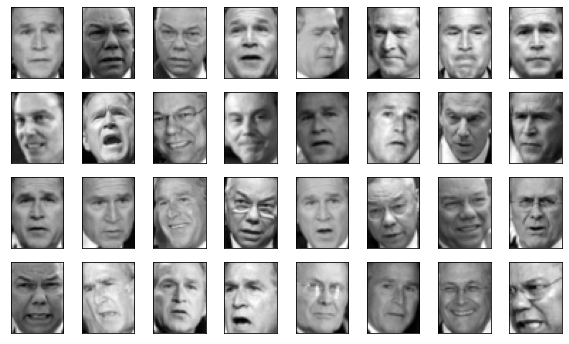

In [28]:
some_samples = train_x[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,0], cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

In [54]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [30]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [56]:
BATCH_SIZE = 32
NUM_EPOCHS = 20

train_ds = tf.data.Dataset.from_tensor_slices((train_x, y_train))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [23]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [57]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 50 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 66.51818084716797
[50] Loss: 24.928186416625977
[100] Loss: 27.435466766357422
[150] Loss: 21.249860763549805
[200] Loss: 16.89388656616211
[250] Loss: 13.39991569519043
[300] Loss: 15.013633728027344
[350] Loss: 7.022477149963379
[400] Loss: 10.780353546142578
[450] Loss: 15.431532859802246
[500] Loss: 14.418585777282715
CPU times: user 3min 5s, sys: 5.15 s, total: 3min 10s
Wall time: 2min 21s


In [58]:
test_embs = model(test_x)

In [59]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

In [60]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs[:])
labels_for_viz = y_test[:]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


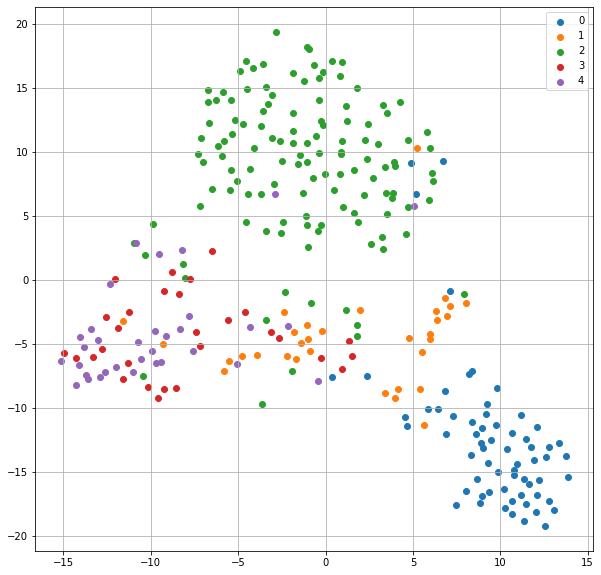

In [61]:
draw_embeddings(test_embs_2D, labels_for_viz, list(range(10)))

In [101]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (50, 37, 1), order=3, mode='reflect', anti_aliasing=True)
    # img = (1. - img).astype(np.float32)
    img = np.mean(img, axis=2)
    img = np.reshape(img, (50, 37, 1))
    return img

img_a1 = load_and_prepare_image('bush_01.jpg')
img_a2 = load_and_prepare_image('bush_02.jpg')
img_b1 = load_and_prepare_image('trump.jpg')

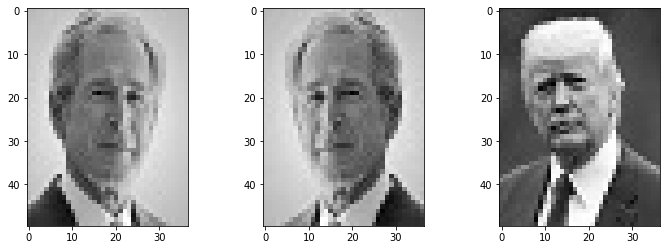

In [102]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1[:,:,0], cmap='gray')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2[:,:,0], cmap='gray')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1[:,:,0], cmap='gray')
plt.show()

In [103]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

In [104]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  3.7943039968800267
A2 <-> B1:  8.675498961244967
A1 <-> B1:  9.423461578039833
